HMDA(The Home Mortgage Disclosure Act)是某国一项法案，他规定金融机构必须将提供抵押贷款的数据向全社会公开。这些数据有助于显示出贷款机构是否为真正需要住房相关的客户而服务，通过分析这些数据，可以对政府官员的决策制定提供帮助，并且有可能揭示某些具有歧视性的贷款模式。
原始数据含有变量共有47个，目标变量为 action_taken_name，可以简单的理解为申请贷款的结果，我们从数据理解入手，展现一个完整的数据挖掘流程。
在该数据集内包含2016年466,566项华盛顿州住房贷款观察数据，变量包括：人口统计资料、地区特定数据、贷款状况、财产类型、贷款类型、贷款目的和来源机构。

实验思路
本实验主要采用pandas加载数据，进行数据的预处理，然后分析属性之间的相关性，探索数据内部的关系，接着采用分类模型算法中的决策树、随机森林、GBDT和XGBoost进行分类预测，并从中挑选出效果相对较好的预测模型，然后采用网格搜索的方式进行最优参数搜索，获取最优分类模型。

本实验具体分工如下：

孙佳怡（组长）25%：数据准备和数据预处理；完整版报告的第一、四、五部分的撰写以及代码和报告的汇总

程诺（组员）10%：数据拆分和决策树模型；完整版报告的第三、四、五部分的撰写以及流程图的绘制

汪涵（组员）20%：随机森林模型；完整版报告的第三、四、五、七部分的撰写

赵彧晨（组员）15%：GBDT模型；完整版报告的第三、四、五、六部分的撰写

褚霁萱（组员）10%：XGBoost模型；完整版报告的第三、四、五部分的撰写

张超楠（组员）20%：模型评估与优化；完整版报告的第二、四、五部分的撰写

In [1]:
import pandas as pd
import seaborn as sns
import missingno #专门用做缺失值的可视化处理库
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

#程序运行过程中忽略警告信息
import warnings
warnings.filterwarnings("ignore")

#导入数据拆分算法train_test_split进行数据集的拆分
from sklearn.model_selection import train_test_split

# 在Jupyter上画图，# 使用该魔法，不用写plt.show()
%matplotlib inline

In [2]:
#这里读取的数据是与项目文件同级目录下，或同一个文件夹中。注意修改路径
hdma_raw = pd.read_csv(r"C:\Users\admin\Desktop\贷款产品预测\Washington_State_HDMA-2016.csv",low_memory=False)

In [3]:
hdma=hdma_raw ### 在原始数据上复制一份数据，往复实验不用再重新读取

In [4]:
### 原始数据的重复性探索，输出结果为False，说明数据集没有重复的记录，不需要去重操作
flag = hdma.duplicated()
flag.any() 

False

In [5]:
hdma.shape #获取数据规模

(466566, 47)

In [6]:
hdma.head(2)

,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,state_name,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,121.690002,NaN,8381.0,23.790001,2175.0,2660.0,227,73300.0,116.0,Washington,...,Female,NaN,NaN,NaN,NaN,"Information not provided by applicant in mail,...",Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Loan originated
1,83.370003,NaN,4915.0,23.990000,1268.0,1777.0,240,57900.0,42.0,Washington,...,Male,NaN,NaN,NaN,NaN,White,Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated


经过数据的初步探索，我们大概了解到了数据集的整体规模，46W+的记录数，47个特征列（含目标列），通过对数据集前2行的简单查看，我们了解到特征列既包含数值类型，也包含字符串类型，且字符串类型较多，后续会分别对各个特征进行探索分析。

### 1、分析目标变量，建模问题简化

##### 目标变量简要分析：对action_taken_name做简要分析，确定并简化分析目标

In [7]:
hdma['action_taken_name'].value_counts()

action_taken_name
Loan originated                                        263712
Application denied by financial institution             64177
Application withdrawn by applicant                      60358
Loan purchased by the institution                       48356
File closed for incompleteness                          18176
Application approved but not accepted                   11735
Preapproval request denied by financial institution        35
Preapproval request approved but not accepted              17
Name: count, dtype: int64

Loan originated意味着贷款申请已经获得批准，Loan purchased是指贷款人在二级市场上购买贷款，而我们的目标旨在“探寻申请人的某些信息或者行为是否会影响到最终贷款的的发放”,因此我们将这两项相关数据集删掉，然后我们将问题简化，将问题转变为一个简单的二分类问题，新增字段loan_status，如果贷款已获批准Loan originated，赋值为0.0，其他情况（即未或批准）为1.0 

In [8]:
#### 多分类目标问题转化为2分类问题
### 删除action_taken_name为“Application withdrawn by applicant”和“Loan purchased by the institution”，并生成新的特征列“loan_status”
hdma=hdma[hdma['action_taken_name']!="Application withdrawn by applicant"]
hdma=hdma[hdma['action_taken_name']!='Loan purchased by the institution']
hdma['loan_status']=[0.0 if x=="Loan originated" else 1.0 for x in hdma['action_taken_name']]


In [9]:
### 删除原先的目标列
del hdma['action_taken_name']

In [10]:
hdma.shape 

(357852, 47)

loan_status
0.0    263712
1.0     94140
Name: count, dtype: int64


<Axes: xlabel='loan_status', ylabel='count'>

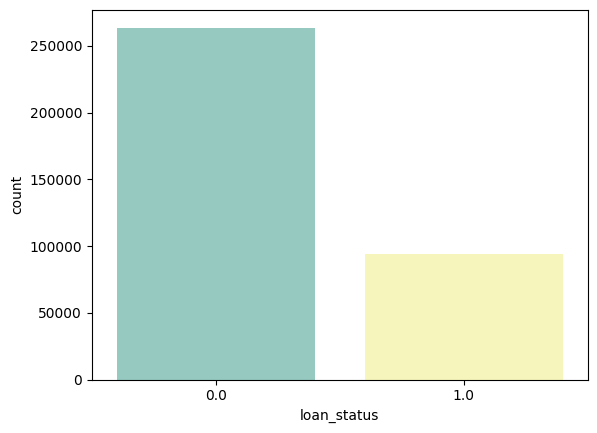

In [11]:
### 查看目标变量的分布情况，并绘制出直方图：
print(hdma['loan_status'].value_counts())
sns.countplot(x='loan_status', data=hdma, palette="Set3")

正负样本比例大致为3:1，并非典型的样本不均衡横问题，在建模前可以不需要做特别的抽样处理（如过采样、欠采样）。

### 2、数据预处理
该步骤先对特征做初步的探索，根据字段类型的不同，将在后续步骤中采取不同的处理方式。

##### 特征的初步分析

In [12]:
hdma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357852 entries, 0 to 466565
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   tract_to_msamd_income           357494 non-null  float64
 1   rate_spread                     8638 non-null    float64
 2   population                      357497 non-null  float64
 3   minority_population             357497 non-null  float64
 4   number_of_owner_occupied_units  357492 non-null  float64
 5   number_of_1_to_4_family_units   357496 non-null  float64
 6   loan_amount_000s                357852 non-null  int64  
 7   hud_median_family_income        357499 non-null  float64
 8   applicant_income_000s           326472 non-null  float64
 9   state_name                      357852 non-null  object 
 10  state_abbr                      357852 non-null  object 
 11  sequence_number                 357852 non-null  int64  
 12  respondent_id        

In [13]:
## 基于对数据初步已知的情况，初步处理数据
#agency_name ，agency_abbr  两列实际含义相同，且取值一一致，选择删除agency_name
del hdma['agency_name'] 

In [14]:
hdma.shape

(357852, 46)

#### 处理缺失数据

<Axes: >

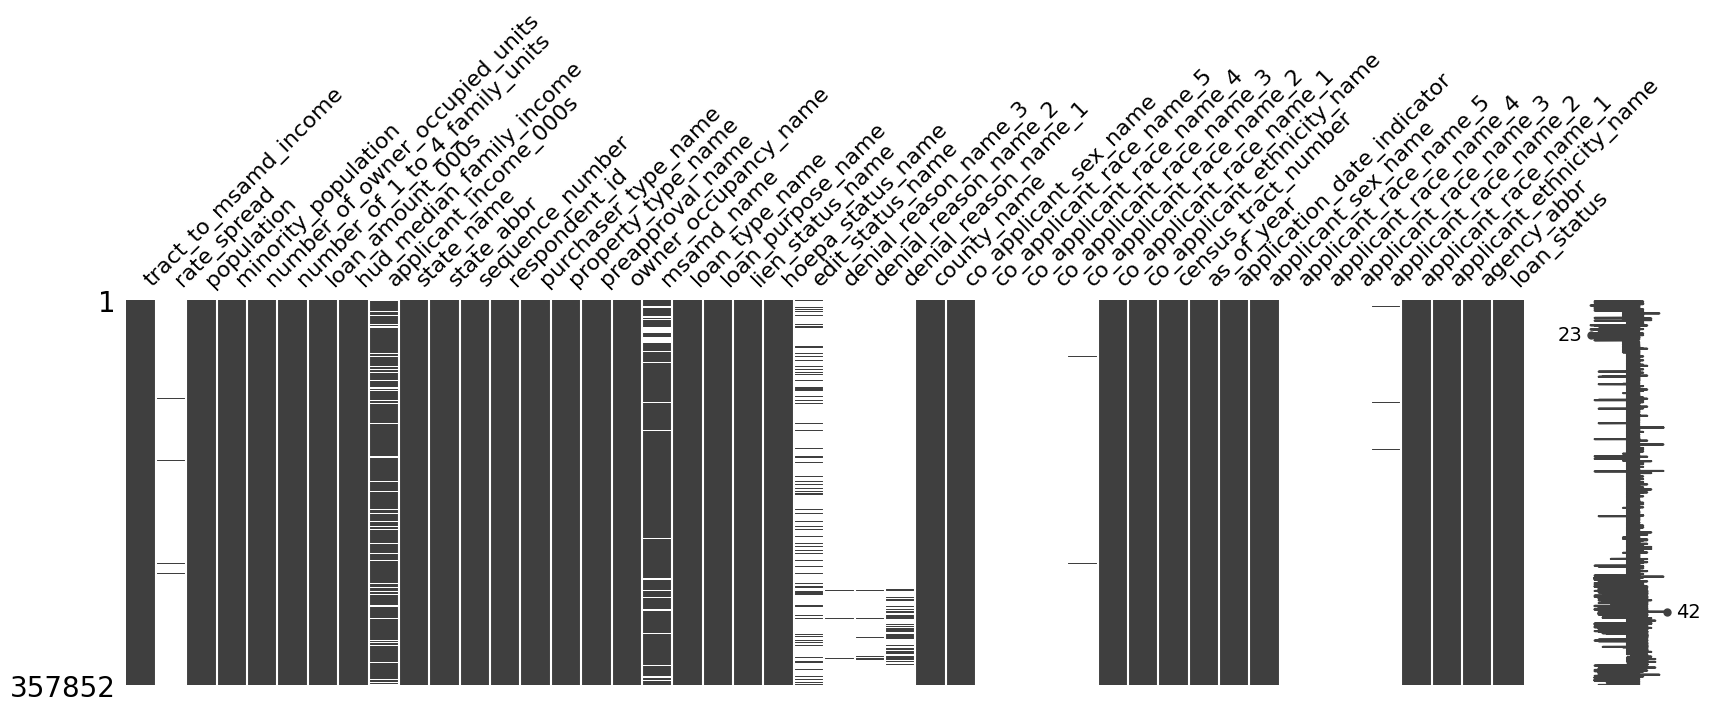

In [15]:
#继续查看数据集所有字段类型为nan的情况
missingno.matrix(hdma, figsize = (20,5))

In [16]:
#统计各特征的缺失率
pd.DataFrame(hdma.isnull().sum()/hdma.shape[0],columns=['miss']).sort_values(by='miss',ascending=False)[:15]

,miss
co_applicant_race_name_5,0.999969
co_applicant_race_name_4,0.999952
applicant_race_name_5,0.999899
applicant_race_name_4,0.999852
co_applicant_race_name_3,0.999748
applicant_race_name_3,0.999327
denial_reason_name_3,0.996518
co_applicant_race_name_2,0.995780
applicant_race_name_2,0.989800
denial_reason_name_2,0.981149


In [17]:
#统计各特征的缺失率,将缺失率大于80%的特征筛选出来直接删除
del_col=[]
for i,column in enumerate(hdma.columns):
    if hdma[column].isnull().sum()/hdma.shape[0] >0.8:
        del_col.append(column)

In [18]:
del_col

['rate_spread',
 'edit_status_name',
 'denial_reason_name_3',
 'denial_reason_name_2',
 'denial_reason_name_1',
 'co_applicant_race_name_5',
 'co_applicant_race_name_4',
 'co_applicant_race_name_3',
 'co_applicant_race_name_2',
 'applicant_race_name_5',
 'applicant_race_name_4',
 'applicant_race_name_3',
 'applicant_race_name_2']

In [19]:
#### 根据info信息直接删除缺失值占比超过80%的特征
hdma=hdma.drop(columns = del_col)

In [20]:
del_col2=[]
for i,column in enumerate(hdma.columns):
    if ((hdma[column].isnull().sum()/hdma.shape[0] <0.2) &(hdma[column].isnull().sum()/hdma.shape[0] >0)):
        del_col2.append(column)

In [21]:
hdma_miss=hdma[del_col2]

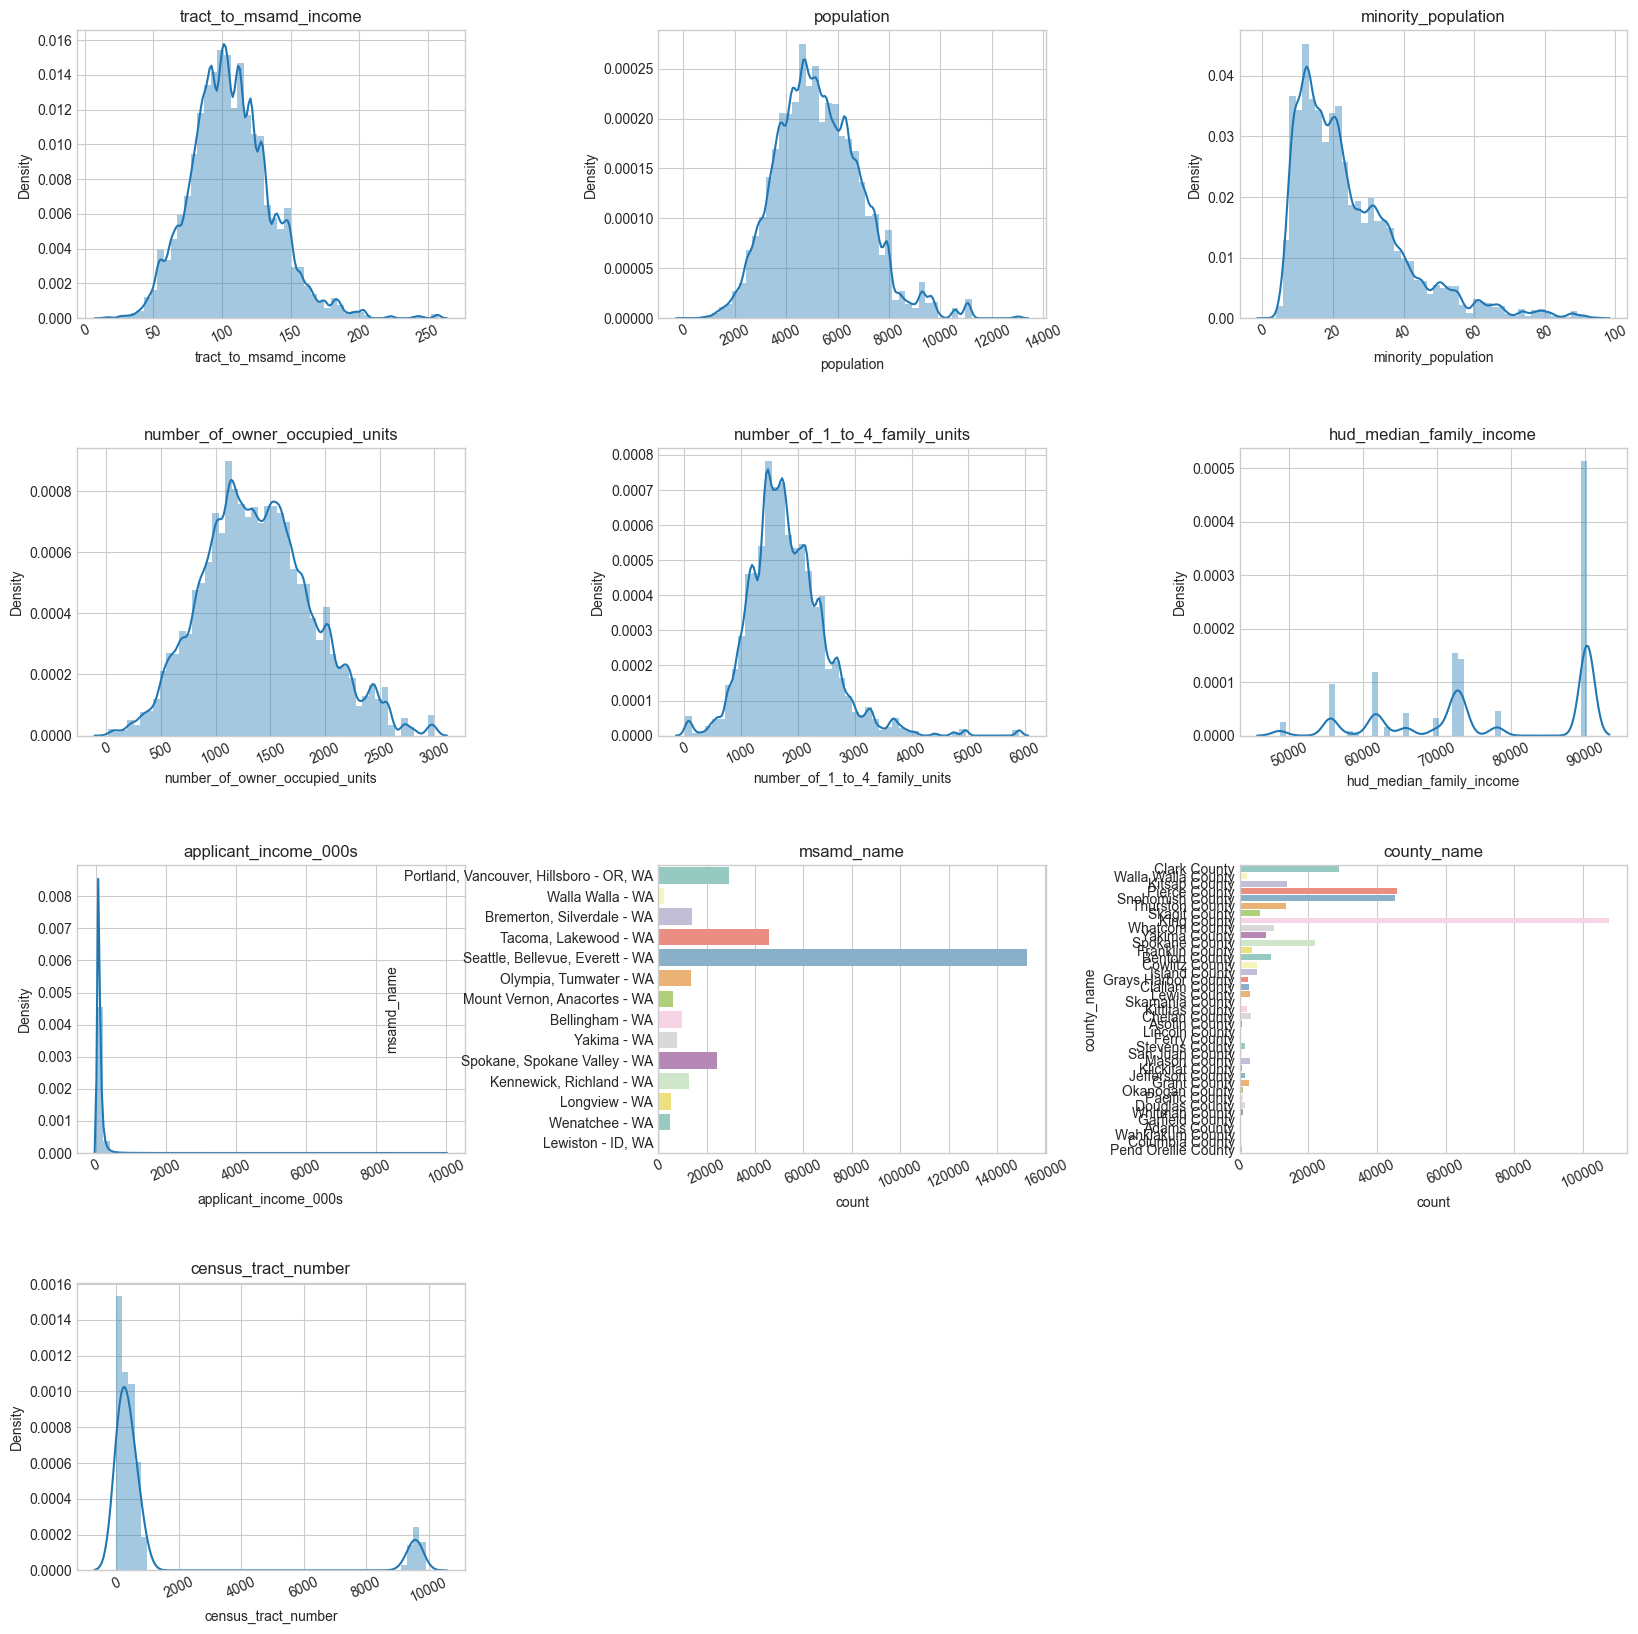

In [22]:
# 绘制每个特征的分布，自定义数据框数据集全部特征分布图
def plot_distribution(df, cols=5, width=15, height=15, hspace=0.2, wspace=0.5):
    import math
    plt.style.use("seaborn-v0_8-whitegrid")     #设置绘画图表风格
    fig = plt.figure(figsize=(width,height))  #创建figure实例
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace) # 调整图表位置和大小间距
    rows = math.ceil(float(df.shape[1]) / cols)    # ceil方法向上取整
    for i, column in enumerate(df.columns):       #返回索引和其对应的列名
        ax = fig.add_subplot(rows, cols, i + 1)         # 创建子图，类似于subplot方法，返回的ax是坐标轴实际画图的位置，参数（子图总行数，总列数，子图位置）
        ax.set_title(column)                            # 设置轴的标题
        if df.dtypes[column] == object:        # 通过列的类型来区分所选取的图像类型,
            g = sns.countplot(y=column, data=df, palette="Set3")   #属性类型为np.object时，countplot使用条形显示每个分箱器中的观察计数，y轴上的条形图
            plt.xticks(rotation=25) 
        else:
            g = sns.distplot(df[column])   #不属于np.object类型即绘制 密度分布图
            plt.xticks(rotation=25)
plot_distribution(hdma_miss, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

In [23]:
hdma=hdma.dropna()     #默认滤除任意有缺失值在的行

In [24]:
hdma.shape

(300175, 33)

#### 根据特征类型，按照数值型与标称型分布分别分析
特征列的类型有int64、float64、object，我们将这些类型分为两个大类进行更严格的探索和分析，第一类，数值类型，包括int64和float64，第二类字符串类型object。并且根据no-null值，可以初步判断有特征列（如applicant_race_name_5、applicant_race_name_4）存在缺失值过多，直接删除特征。

In [25]:
## 查看数值型属性统计性描述
hdma.describe()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,census_tract_number,as_of_year,application_date_indicator,loan_status
count,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,3.001750e+05,300175.000000,300175.0,300175.0,300175.000000
mean,107.565574,5318.159723,25.528260,1385.743153,1770.756715,290.625895,78976.084284,114.543616,9.616981e+04,929.199688,2016.0,0.0,0.255791
std,30.113663,1624.899427,15.218358,498.786135,610.076896,392.651777,11889.894229,125.846933,1.711085e+05,2261.752846,0.0,0.0,0.436306
min,14.050000,98.000000,2.040000,14.000000,27.000000,1.000000,48700.000000,1.000000,1.000000e+00,1.000000,2016.0,0.0,0.000000
25%,87.209999,4181.000000,14.110000,1033.000000,1385.000000,176.000000,72300.000000,61.000000,4.404000e+03,117.000000,2016.0,0.0,0.000000
50%,105.029999,5192.000000,21.320000,1361.000000,1719.000000,254.000000,78100.000000,90.000000,2.292000e+04,321.020000,2016.0,0.0,0.000000
75%,125.430000,6364.000000,33.220001,1701.000000,2142.000000,360.000000,90300.000000,135.000000,9.121250e+04,528.060000,2016.0,0.0,1.000000
max,257.140015,11041.000000,94.790001,2997.000000,4746.000000,99999.000000,90300.000000,9999.000000,1.241016e+06,9705.000000,2016.0,0.0,1.000000


In [26]:
# 标量型特征属性统计性描述
hdma.describe(include=['O'])

,state_name,state_abbr,respondent_id,purchaser_type_name,property_type_name,preapproval_name,owner_occupancy_name,msamd_name,loan_type_name,loan_purpose_name,lien_status_name,hoepa_status_name,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr
count,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175
unique,1,1,704,10,2,3,3,14,4,3,3,2,21,5,8,5,4,7,4,6
top,Washington,WA,451965,Loan was not originated or was not sold in cal...,One-to-four family dwelling (other than manufa...,Not applicable,Owner-occupied as a principal dwelling,"Seattle, Bellevue, Everett - WA",Conventional,Refinancing,Secured by a first lien,Not a HOEPA loan,King County,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,HUD
freq,300175,300175,18708,124245,292780,246852,276457,143098,236843,153318,288432,300166,101475,142943,142943,142943,194477,215898,242849,155187


top描述的是出现频率最高的字段，而freq则是描述该字段出现的次数。

In [27]:
### 根据统计描述，处理分布极端的特征：筛选出来取值只有1个值的特征
del_col2=[]
for i, column in enumerate(hdma.columns):
    if len(hdma[column].unique())==1:
        del_col2.append(column)
print(del_col2)
hdma=hdma.drop(columns = del_col2)
hdma.shape

['state_name', 'state_abbr', 'as_of_year', 'application_date_indicator']


(300175, 29)

##### 对其他数值类型的变量做相关性分析。
特征相关性分析，去除相关性较高的特征之一

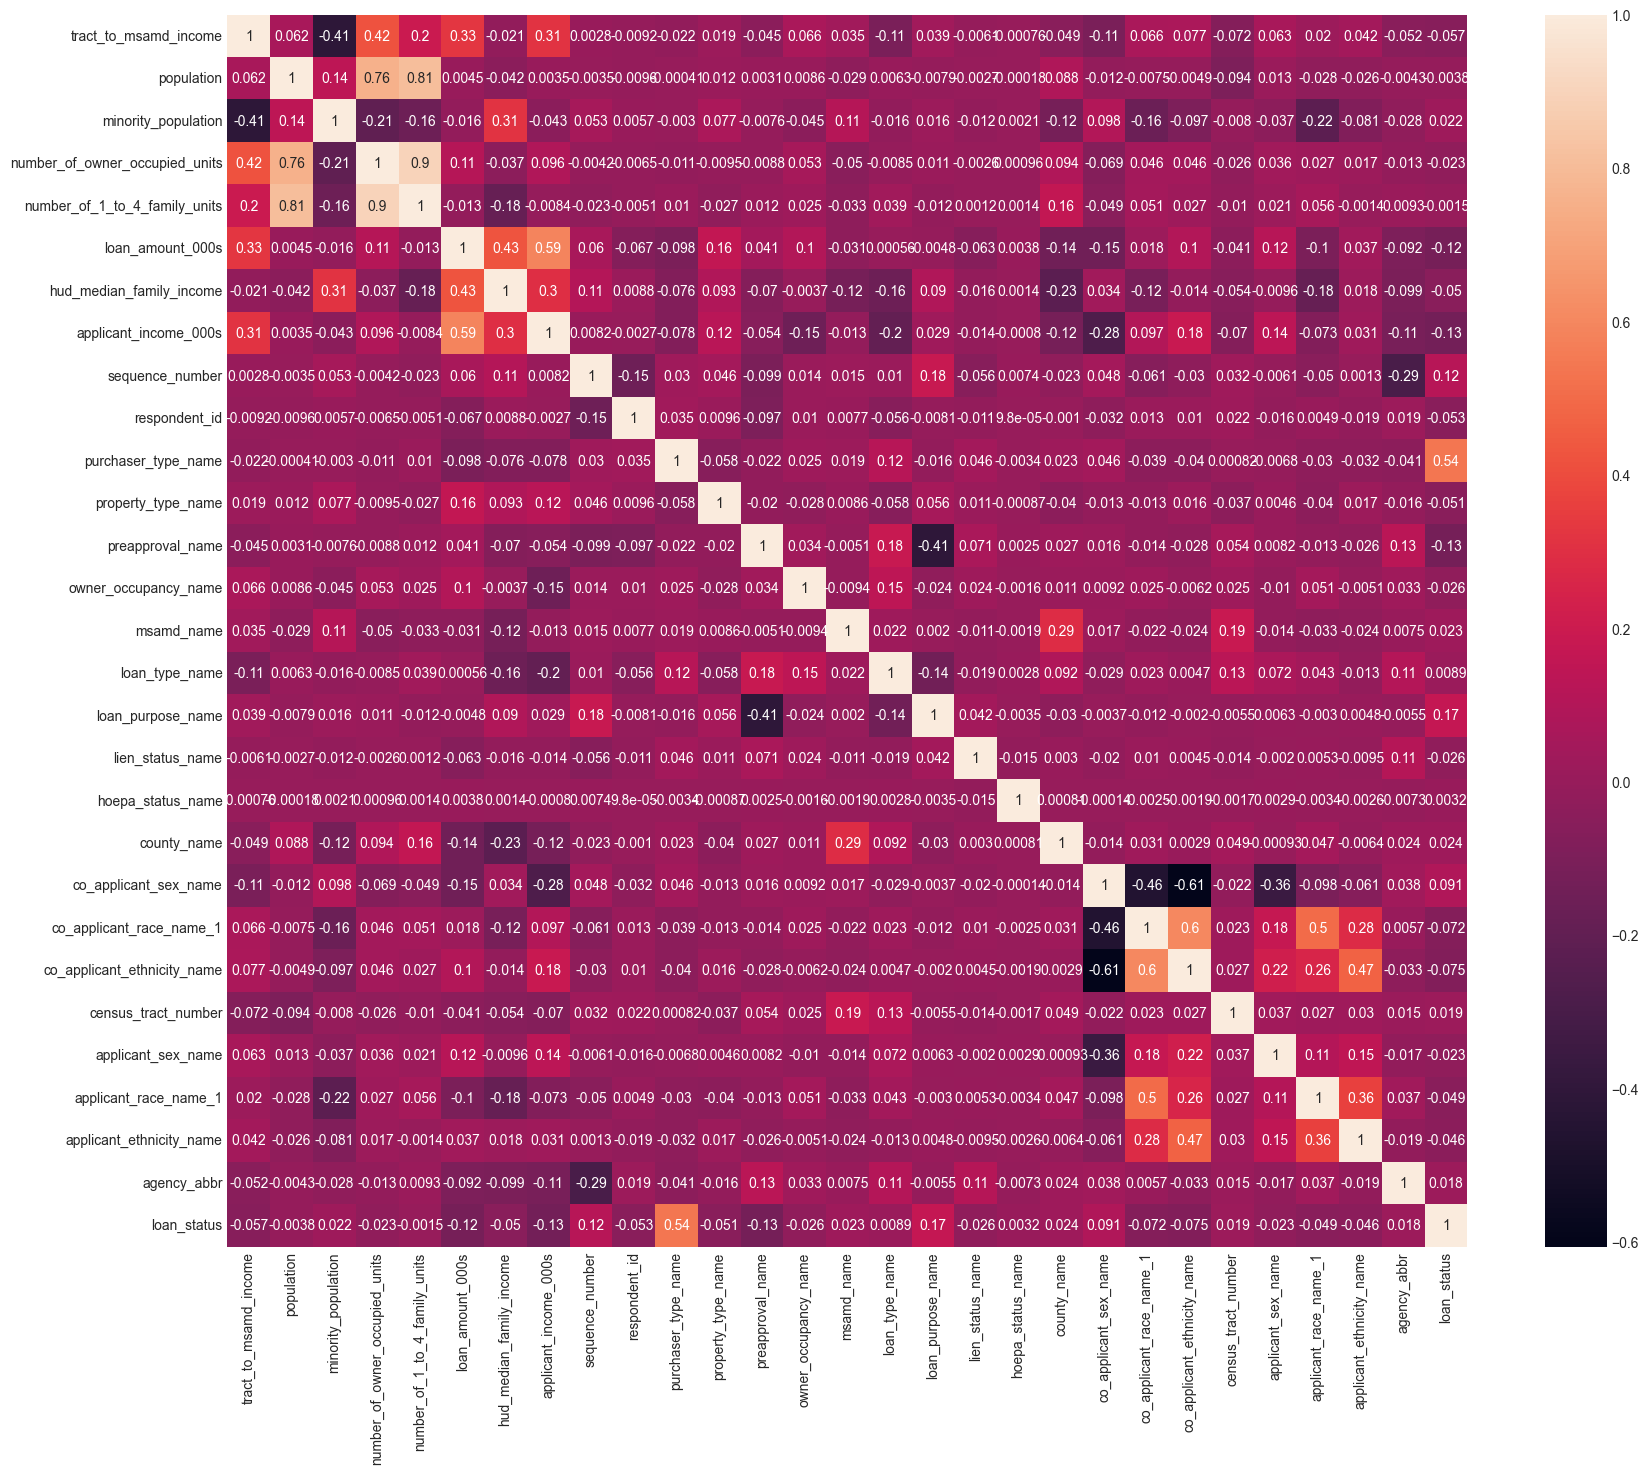

In [28]:
### 分箱之后的相关性，必须要全部编码后，在以spearman方式查看
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 对于非数值列，使用 LabelEncoder 或 pd.factorize 进行编码
label_encoder = LabelEncoder()
for column in hdma.columns:
    if hdma[column].dtype == 'object':
        # 尝试数值化，如果报错则进行编码
        try:
            hdma[column] = pd.to_numeric(hdma[column])
        except ValueError:
            hdma[column] = label_encoder.fit_transform(hdma[column])

# 现在计算相关性矩阵时将不再报错
plt.figure(figsize=(20, 16))
sns.heatmap(hdma.corr(method='spearman'), annot=True) # 使用'Spearman'相关性
plt.show()



可以看出，'population'、'number_of_owner_occupied_units'、'number_of_1_to_4_family_units'这3个特征相关度（大于70%）很高，可以考虑只保留一个。这里保留population字段。

In [29]:
del hdma['number_of_owner_occupied_units']
del hdma['number_of_1_to_4_family_units']

In [30]:
## 筛选出来那些标准差大于100的特征
bins_col=[]
for i, column in enumerate(hdma.columns):
    if hdma.dtypes[column] != object: 
        if hdma[column].std()>100:
            bins_col.append(column)  #记录下符合分箱条件的列
print(bins_col)
hdma[bins_col].describe() ##查看是哪些列被分箱

['population', 'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s', 'sequence_number', 'respondent_id', 'census_tract_number']


,population,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,respondent_id,census_tract_number
count,300175.000000,300175.000000,300175.000000,300175.000000,3.001750e+05,300175.000000,300175.000000
mean,5318.159723,290.625895,78976.084284,114.543616,9.616981e+04,368.969904,929.199688
std,1624.899427,392.651777,11889.894229,125.846933,1.711085e+05,193.234815,2261.752846
min,98.000000,1.000000,48700.000000,1.000000,1.000000e+00,0.000000,1.000000
25%,4181.000000,176.000000,72300.000000,61.000000,4.404000e+03,225.000000,117.000000
50%,5192.000000,254.000000,78100.000000,90.000000,2.292000e+04,371.000000,321.020000
75%,6364.000000,360.000000,90300.000000,135.000000,9.121250e+04,557.000000,528.060000
max,11041.000000,99999.000000,90300.000000,9999.000000,1.241016e+06,703.000000,9705.000000


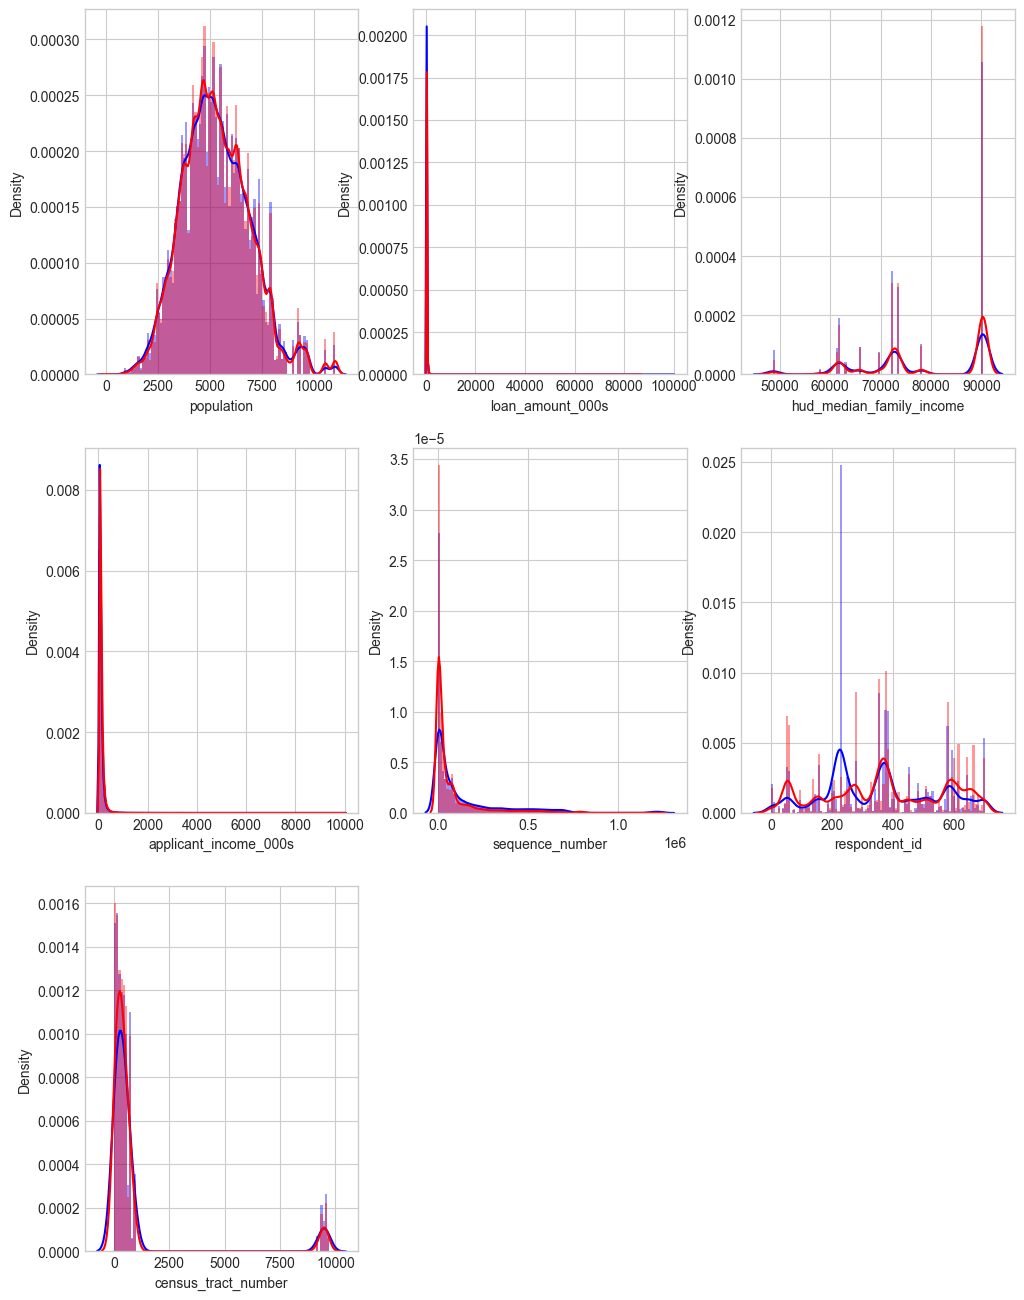

In [31]:
###这些数值变量在目标变量不同时分布情况是否有明显变化
###对数值特征中，标准差大于100的特征进行分箱
plt.figure(figsize=(12,28*2))
gr = gridspec.GridSpec(10, 3)
for i,j in enumerate(bins_col):
    ax = plt.subplot(gr[i])
    sns.distplot(hdma[j][hdma.loan_status == 1], bins=100, color='b')
    sns.distplot(hdma[j][hdma.loan_status == 0], bins=100, color='r')
#     ax.set_title('feature: ' + str(j))
plt.show()

In [32]:
hdma.shape

(300175, 27)

In [33]:
#####  对数值特征中，标准差大于100的特征进行分箱
hdma[column]= pd.cut(hdma[column], 100)

LabelEncoder
即将离散型的数据转换成0到 n−1 之间的数，n 是一个列表的不同取值的个数，可以认为是某个特征的所有不同取值的个数。

In [34]:
### 特征编码
# 转换为连续型数字变量
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# print(dataset_con['workclass'])
hdma = hdma.astype(str)
hdma_enc = hdma.apply(encoder.fit_transform) 

In [35]:
hdma_enc.describe()

,tract_to_msamd_income,population,minority_population,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,respondent_id,purchaser_type_name,property_type_name,...,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,census_tract_number,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr,loan_status
count,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,...,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000
mean,563.213852,676.612516,509.082628,879.730351,10.283625,675.690471,67087.250664,361.869499,5.004008,0.975364,...,11.986991,1.674733,5.359210,2.284964,507.891913,1.388077,4.922712,1.757728,2.032794,0.255791
std,355.129194,312.362060,310.848409,335.436209,3.394708,422.868039,40350.707579,185.721632,2.279002,0.155012,...,6.581656,1.385786,1.620519,0.720627,316.920292,0.870356,1.810047,0.536200,1.466589,0.436306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,258.000000,432.000000,241.000000,709.000000,9.000000,276.000000,31998.000000,199.000000,2.000000,1.000000,...,6.000000,0.000000,5.000000,2.000000,220.000000,0.000000,3.000000,2.000000,0.000000,0.000000
50%,500.000000,711.000000,488.000000,906.000000,12.000000,705.000000,65435.000000,318.000000,6.000000,1.000000,...,13.000000,2.000000,5.000000,2.000000,495.000000,2.000000,6.000000,2.000000,3.000000,0.000000
75%,897.000000,946.000000,751.000000,1073.000000,13.000000,1057.000000,103116.500000,533.000000,7.000000,1.000000,...,19.000000,3.000000,7.000000,3.000000,779.000000,2.000000,6.000000,2.000000,3.000000,1.000000
max,1183.000000,1154.000000,1096.000000,1771.000000,13.000000,1370.000000,136748.000000,703.000000,9.000000,1.000000,...,20.000000,4.000000,7.000000,4.000000,1075.000000,3.000000,6.000000,3.000000,5.000000,1.000000


In [36]:
hdma_enc.shape

(300175, 27)

### 建立模型

In [37]:
#将数据拆分为训练数据和测试数据
x_cols = [col for col in hdma_enc.columns if col!='loan_status' ]
y_col = 'loan_status'
X=hdma_enc[x_cols]
y=hdma_enc[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [38]:
X

,tract_to_msamd_income,population,minority_population,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,respondent_id,purchaser_type_name,property_type_name,...,hoepa_status_name,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,census_tract_number,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr
0,304,1128,462,801,10,104,8082,309,4,1,...,1,14,2,3,3,554,0,3,2,0
1,936,644,471,835,1,756,92513,533,6,1,...,1,10,3,5,2,984,2,6,0,3
2,1058,689,63,838,10,110,104710,532,7,1,...,1,14,0,7,3,561,2,6,2,3
3,478,678,1033,1027,10,604,34647,311,7,1,...,1,14,0,3,1,486,2,3,1,4
4,539,715,17,1108,12,94,62081,199,4,1,...,1,20,2,7,3,957,0,6,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452834,689,291,282,962,9,1239,120298,141,7,1,...,1,3,3,5,2,908,2,6,2,3
452837,449,1115,213,1228,13,461,119047,141,7,1,...,1,19,1,3,1,202,1,3,1,3
464253,22,1136,746,987,4,1124,119734,141,7,1,...,1,4,0,7,3,1046,2,6,2,3
466564,1021,596,823,874,9,1155,120984,141,7,1,...,1,3,0,7,3,829,2,6,2,3


In [39]:
import time,datetime

In [40]:
#导入决策树模型
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
#采用决策树模型进行训练
dt_model.fit(X_train, y_train)
y_pred=dt_model.predict(X_test)
#打印模型评估值
print (dt_model.score(X_test, y_test))

0.8817141016956681


In [41]:
#导入随机森林模型
from sklearn.ensemble import RandomForestClassifier
#配置模型中树的个数为100
rf_model = RandomForestClassifier (n_estimators=100)
#采用随机森林进行模型训练
rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_test)
#打印模型评分结果 
print (rf_model.score(X_test, y_test))  

0.9011582068337535


<Axes: >

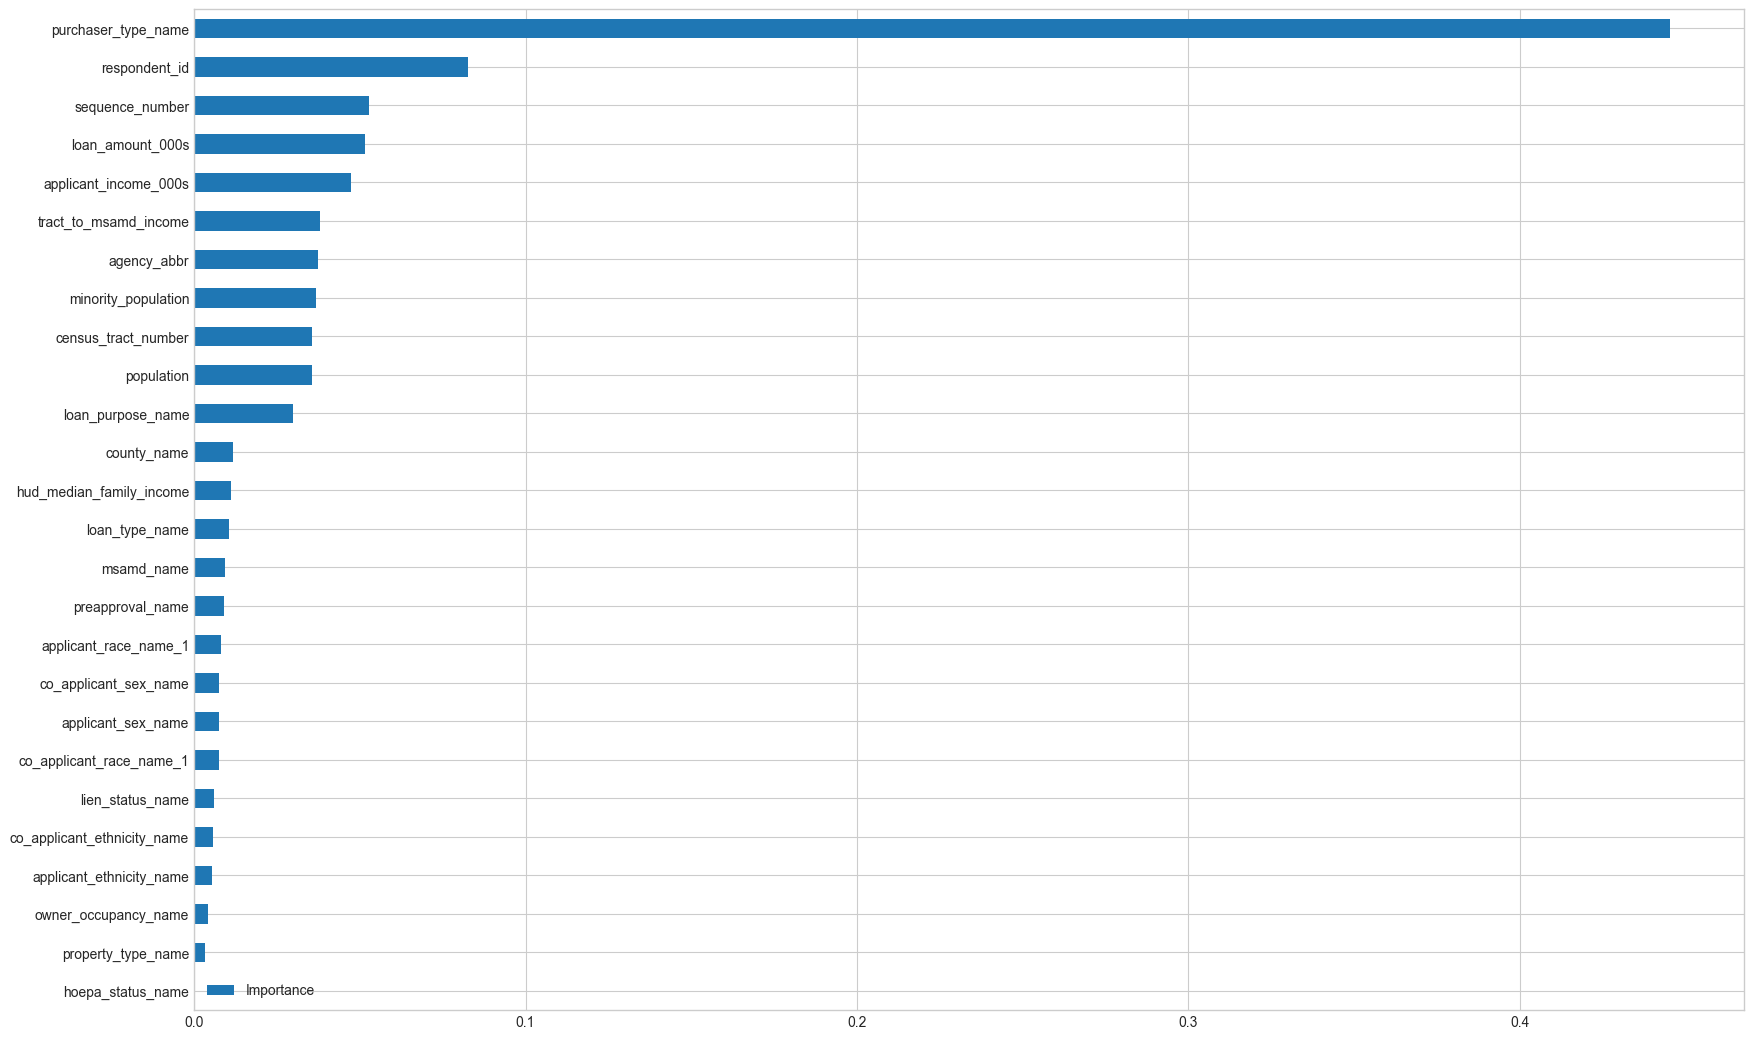

In [42]:
# 使用随机森林算法去查看属性重要性
plt.style.use("seaborn-v0_8-whitegrid")
importance = rf_model.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=["Importance"])
#根据数值大小排序
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2))

In [43]:
###  查看重要性突出的特征的分布（在原始数据中取值，训练用的已经编码处理了）
hdma['purchaser_type_name'].value_counts()

purchaser_type_name
7    124245
2     61291
4     39450
5     26251
6     17798
1     15883
8     10506
0      3186
9      1552
3        13
Name: count, dtype: int64

In [44]:
#导入GBDT模型
from sklearn.ensemble import GradientBoostingClassifier
#配置GBDT分类器个数
gbdt_model = GradientBoostingClassifier(n_estimators=100)
#采用训练数据集进行模型训练
gbdt_model.fit(X_train, y_train)
y_pred=gbdt_model.predict(X_test)
#输出模型评估值
print (gbdt_model.score(X_test, y_test))

0.8921857128579836


算法解读：对比原算法GBDT，XGBoost主要从下面三个方面做了优化：

　　一是算法本身的优化：在算法的弱学习器模型选择上，对比GBDT只支持决策树，还可以直接很多其他的弱学习器。在算法的损失函数上，除了本身的损失，还加上了正则化部分。在算法的优化方式上，GBDT的损失函数只对误差部分做负梯度（一阶泰勒）展开，而XGBoost损失函数对误差部分做二阶泰勒展开，更加准确。
  
　　二是算法运行效率的优化：对每个弱学习器，比如决策树建立的过程做并行选择，找到合适的子树分裂特征和特征值。在并行选择之前，先对所有的特征的值进行排序分组，方便前面说的并行选择。对分组的特征，选择合适的分组大小，使用CPU缓存进行读取加速。将各个分组保存到多个硬盘以提高IO速度。
  
　　三是算法健壮性的优化：对于缺失值的特征，通过枚举所有缺失值在当前节点是进入左子树还是右子树来决定缺失值的处理方式。算法本身加入了L1和L2正则化项，可以防止过拟合，泛化能力更强。

In [45]:
#导入XGBoost分类模型

import xgboost as xgb  #主要是c语言实现的，本实验是通过python接口调用
xgb_model_1 = xgb.XGBClassifier(
max_depth=6                    #构建树的深度，越大越容易过拟合,需要使用 CV 函数来进行调优。 典型值：3-10 
,learning_rate=0.3             #学习率
,n_estimators=100              #树的个数    
,scale_pos_weight=1            #两种类别的权重设置，如果设置为大于1，会加快收敛，
,objective='binary:logistic'   #设置目标函数，此处为二分类对应的目标函数，输出对应分类结果的概率 	
,eval_metric='auc'             #分类任务(默认error)  ,auc--roc曲线下面积
,subsample=1                   #控制对于每棵树，随机采样的比例。 典型值：0.5-1
,seed=123                      #随机数种子,用于产生可复现的结果 
)


#采用训练数据集进行模型训练
xgb_model_1.fit(X_train, y_train)
y_pred=xgb_model_1.predict(X_test)
#输出模型评估值
print (xgb_model_1.score(X_test, y_test))

0.9080208321766071


##### 选择XGBoost算法进行交叉验证

In [46]:
###选择XGBoost算法进行交叉验证
#首先通过交叉验证的方式检查样本分布不均是否对模型造成影响
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,roc_auc_score,make_scorer,f1_score
from sklearn.model_selection import cross_val_score,GridSearchCV

cv_scores = cross_val_score(xgb_model_1, X_train, y_train,scoring=make_scorer(f1_score) ,cv=3)
print('mean f1_score socre of raw model {}'.format(np.mean(cv_scores)))

mean f1_score socre of raw model 0.8165732003813014


选出XGBoost算法进行最后预测模型，对其参数进行网格搜索

### **网格搜索**

   网格搜索（GridSearch）用于选取模型的最优超参数。获取最优超参数的方式可以绘制验证曲线，但是验证曲线只能每次获取一个最优超参数。如果多个超参数有很多排列组合的话，就可以使用网格搜索寻求最优超参数的组合。 

**GridSearchCV()**
    **estimator:**选择使用的分类器，并且传入除需要确定最佳的参数之外的其他参数。
    **param_grid:**需要最优化的参数的取值，值为字典或者列表，键命名必须为模型本身的参数名称
    **scoring：**模型评价标准，默认None(即选择的estimator的误差估计函数)。常为'f1','accuracy','recall','roc_auc',‘average_precision’
    **cv=None,**交叉验证参数，默认3

**网格搜索过渡方法-坐标下降**：拿当前对模型影响最大的参数调优，直到最优化；再拿下一个影响最大的参数调优，如此下去，直到所有的参数调整完毕。这个方法的缺点就是可能会调到局部最优而不是全局最优，但是省时间省力。如下即使用坐标下降的思路进行超参数调优。

##### 4.3.2 网格搜索参数调整，调节scale_pos_weight

尝试找的较匹配的参数，进而提升模型性能 根据前面的参数设置，我们仅从3个比较主要的参数入手进行网格搜索 

n_estimators         #树的个数

max_depth            #构建树的深度，越大越容易过拟合

learning_rate        #学习率 

In [47]:
# 训练开始计时
start_time = time.time()

#### 利用坐标下降的方式，对XGBoost模型的关键参数进行搜索，尝试获取更好的建模结果
#首先对参数 n_estimators 进行搜索
param_test1 = {'n_estimators':range(90,151,20)}
gsearch1 = GridSearchCV(estimator = xgb_model_1, 
                        param_grid = param_test1,
                        scoring=make_scorer(f1_score)
                       )
gsearch1.fit(X_train,y_train)
print('best params:{}'.format(gsearch1.best_params_))
print('best score:{}'.format(gsearch1.best_score_))

# 训练结束计时
print("Running Time: %s" % datetime.timedelta(seconds=(time.time() - start_time)))

best params:{'n_estimators': 150}
best score:0.8202755316059784
Running Time: 0:00:33.514853


In [48]:
#首先对参数 max_depth 进行搜索
param_test2 = {'max_depth':range(3,10,2)}
gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_,
                        param_grid = param_test2,
                        scoring=make_scorer(f1_score))
gsearch2.fit(X_train,y_train)
print('best params2:{}'.format(gsearch2.best_params_))
print('best score:{}'.format(gsearch2.best_score_))

best params2:{'max_depth': 5}
best score:0.8196730274156211


In [49]:
#首先对参数 learning_rate 进行搜索
param_test3 = {'learning_rate':[0.05,0.1,0.3,0.5,0.7]}
gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_,
                        param_grid = param_test3,
                        scoring=make_scorer(f1_score))
gsearch3.fit(X_train,y_train)
print('best params3:{}'.format(gsearch3.best_params_))
print('best score:{}'.format(gsearch3.best_score_))

best params3:{'learning_rate': 0.3}
best score:0.8196730274156211


In [50]:
gsearch3.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
import joblib
joblib.dump(gsearch3.best_estimator_,'xgb_model.pkl')

['xgb_model.pkl']

In [52]:
model_load = joblib.load('xgb_model.pkl')
y_test_pred = model_load.predict(X_test)
print('f1 score of random forest score:{}'.format(f1_score(y_test,y_test_pred)))


f1 score of random forest score:0.8211656441717792


 **XGBoost模型小结：**该模型本身的参数优化 效果一般不是特别大，更为重要的是数据清洗和特征工程。 

In [53]:
X2=hdma_enc.drop(['loan_status','purchaser_type_name'],axis=1)
y2=hdma_enc['loan_status']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=10)